In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

## Test case: how to use histograms to show time spent in a bin

[0 2 1 1 1 0]
[0 4 1 1 2 0]


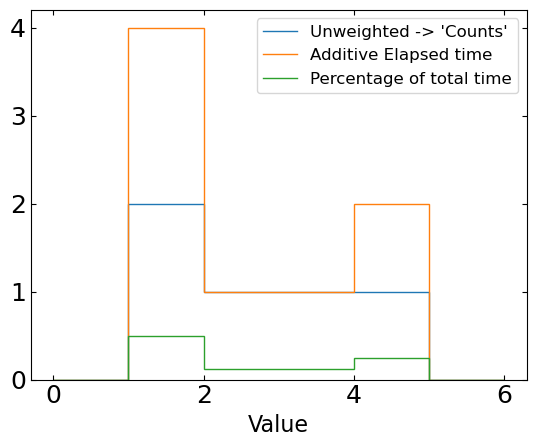

In [7]:
## test case for arrays 
xx = np.array([1,2,3,4,1.5]) # val
yy = np.array([3,1,1,2,1]) # hours spent at val

unscaled_vals, unscaled_edges = np.histogram(xx,bins=range(7))
scaled_vals, scaled_edges = np.histogram(xx,bins=range(7),weights=yy)
weighted_vals, weighted_edges = np.histogram(xx,bins=range(7),weights=yy/np.sum(yy))

plt.stairs(unscaled_vals,unscaled_edges,label="Unweighted -> 'Counts'")
plt.stairs(scaled_vals,unscaled_edges,label="Additive Elapsed time")
plt.stairs(weighted_vals,unscaled_edges,label="Percentage of total time")
plt.xlabel("Value")
plt.legend(fontsize=12)

print(unscaled_vals)
print(scaled_vals)

So:
- no weighting gives the number of times a pair is found at a separation
- weighting by the elapsed time will yield the total time spent in the separation bin
- weighting by the elapsed time divided by total time gives percentage of time spent in each bin


This means: 

**we will use a histogram weighted by the elapsed time between each snapshot to calculate the time spent in each separation bin!**

**we can also use the weighted by percentage of elapsed time to give the relative amount of time the pair spends at each separation** < for this might need to remove the times after merger to prevent excessive time ? 

## First histogram for 1 pair

In [4]:
f = h5py.File(f"{paths.path_data}orbitdata_40.hdf5",'r')
check_dict = {}
for key, val in f.items():
    check_dict[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

In [7]:
merge_ind = 2
nomerge_ind = 10

In [8]:
# get the lookback time at each of the snaps where separation is defined

defined_mask = ~np.isnan(check_dict["Separations"][merge_ind])
full_snaps = np.arange(99,0,-1)
defined_snaps = full_snaps[defined_mask]

# get mask for the lookback times associate with each snapshot
snap_mask = np.isin(snap_dict["Snapshot"],defined_snaps)
lookbacks = snap_dict["Lookback Time"][snap_mask][::-1] # since lookback array starts at snap 0 to 99

seps = check_dict["Separations"][merge_ind][defined_mask]


In [9]:
elapsed_time = np.diff(lookbacks)
seps_shifted = seps[1:] # drop the z=0 snapshot 99 separation since it's been at that sep for "0" time

elapsed_time

array([0.13648833, 0.20358627, 0.13494672, 0.20123119, 0.13334835,
       0.19879143, 0.13169392, 0.19626828, 0.12998441, 0.19366342,
       0.19206215, 0.12713793, 0.18933118, 0.12529192, 0.18652493,
       0.18480638, 0.12223704, 0.18188661, 0.1801028 , 0.1190662 ,
       0.23569747, 0.11661877, 0.17337391, 0.17149186, 0.11327335,
       0.16831549, 0.16638777, 0.16444505, 0.16248854, 0.16051947,
       0.15853907, 0.15654861, 0.15454935, 0.15254256, 0.20025778,
       0.14783793, 0.14581523, 0.1437905 , 0.18856991, 0.1390652 ,
       0.18227452, 0.13435103, 0.17600395, 0.12966278, 0.16977741,
       0.16624613, 0.16273829, 0.11976751, 0.19529422, 0.15238472,
       0.14899911, 0.14565035, 0.1423406 , 0.17333408, 0.1350464 ,
       0.16435557, 0.15949336, 0.15472505, 0.20878849, 0.08674488,
       0.16868103, 0.1357744 , 0.15733133, 0.1513932 , 0.14563402,
       0.16286559, 0.15555149, 0.14851608, 0.14175526, 0.15407306,
       0.14598782, 0.15504758, 0.14582497, 0.09234402, 0.20121

> note for later:  that maybe I should take the diff array, THEN mask the elapsed times so that I can account for "skipped" snapshots? that would make it so that one skipped snapshot doesn't result in a distance being used for 2 times longer than it should be and won't require interpolation ~ 

[28  4  4  2  3  4  4  2  4  5  4  4  5  2  5]
[4.57805312 0.63809569 0.65518762 0.31559264 0.43969941 0.66637736
 0.48391474 0.09921041 0.31802984 0.35638028 0.34163765 0.39102683
 0.54918677 0.2967388  0.79237618]


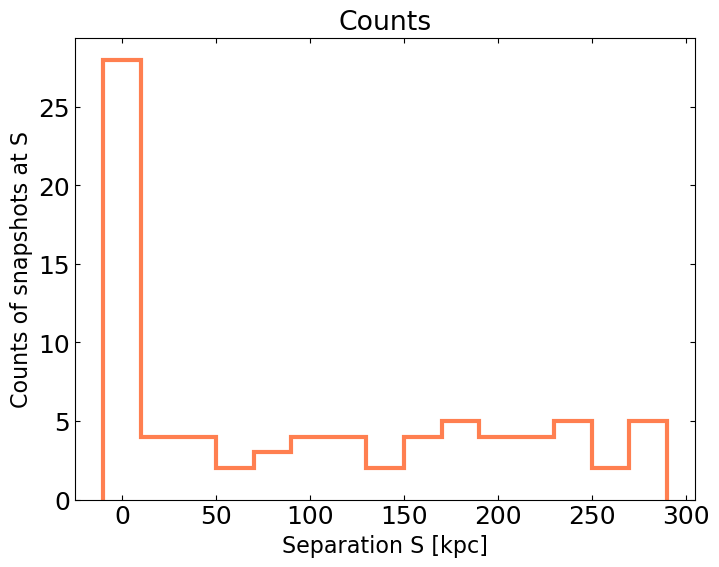

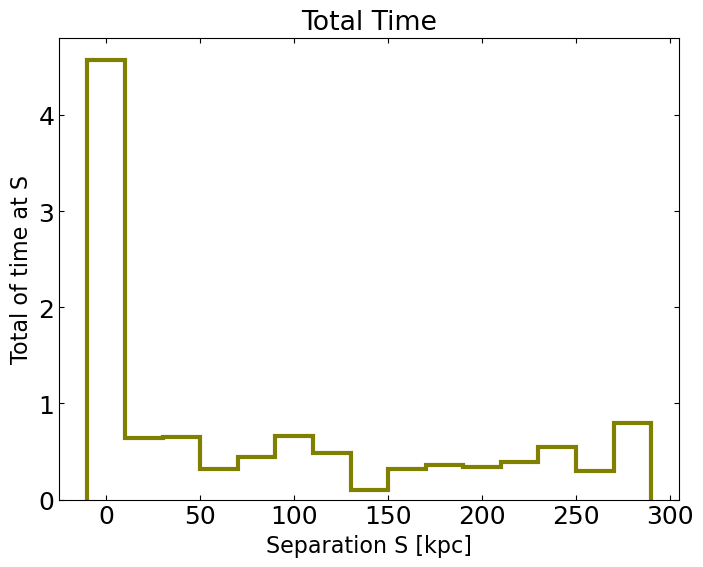

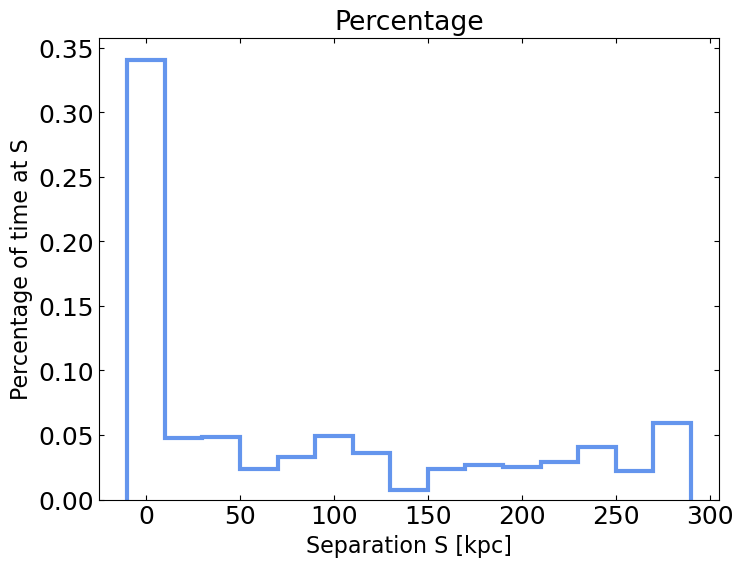

In [22]:
## first example of merged pair
xx = seps_shifted
yy = elapsed_time
bins = np.arange(-10,300,20)

unscaled_vals, unscaled_edges = np.histogram(xx,bins=bins)
scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy)
weighted_vals, weighted_edges = np.histogram(xx,bins=bins,weights=yy/np.sum(yy))

fig = plt.figure(figsize=(8,6))
plt.title("Counts")
plt.stairs(unscaled_vals,unscaled_edges,color="coral",lw=3)
plt.xlabel("Separation S [kpc]")
plt.ylabel("Counts of snapshots at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3)
plt.title("Total Time")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(weighted_vals,unscaled_edges,color="cornflowerblue",lw=3)
plt.title("Percentage")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Percentage of time at S")


print(unscaled_vals)
print(scaled_vals)

Just like I thought, the 0 separation chunk really dominates. Gonna try making the elapsed time array first, THEN masking out the nans and zeros. 

### Removing all the entries after merger 

In [10]:
merge_ind = 2
nomerge_ind = 10

# full elapsed time array
elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])
elapsed_snapshot = np.diff(snap_dict["Snapshot"][1:][::-1])
print("Original elapsed time array length:",len(elapsed_time))

# remove the z=0 element since that one has 0 elapsed time ~
seps_full = check_dict["Separations"][merge_ind]
print("Original separation array length:",len(seps_full))
seps_non0 = seps_full[1:] # remove z=0 sep

# create mask to remove nans and 0 separations 
nan_mask = np.isnan(seps_non0)
zero_mask = seps_non0==0
combined_mask = ~nan_mask&~zero_mask

# getting the masked arrays
elapsed_masked = elapsed_time[combined_mask]
elapsed_snap_masked = elapsed_snapshot[combined_mask]
seps_masked = seps_non0[combined_mask]

print("Final array lengths:",len(seps_masked),len(elapsed_masked))


Original elapsed time array length: 98
Original separation array length: 99
Final array lengths: 71 71


In [24]:
seps_masked

array([  4.62281476,   5.97926507,  10.16760077,  21.99154963,
        17.13413469,  27.83340596,  43.98711832,  46.87983281,
        36.2004837 ,  41.30782678,  59.1167501 ,  75.74506704,
        95.01645957, 108.04207611, 112.33231094, 110.64704929,
        98.42775339,  84.00636291,  64.09989665,  70.01172396,
        99.07474193, 117.8658706 , 151.58251945, 180.84111806,
       204.00065532, 229.12080898, 244.30706323, 268.94303249,
       279.94551736, 282.58659091, 287.28941435, 293.47738632,
       308.31540014, 314.79777829, 325.27218505, 332.62968748,
       344.33020666, 353.78975287, 363.63237677, 367.38487931,
       361.45861583, 352.23902085, 345.53552375, 341.21322527,
       328.39220405, 318.66770807, 309.2448255 , 298.08920397,
       283.1130251 , 273.72273487, 258.48498587, 245.45578442,
       242.33876517, 238.47143871, 233.81622716, 226.8408052 ,
       221.79825335, 214.27530542, 208.37971127, 205.38510814,
       198.25901514, 189.16566807, 184.97092544, 179.75

In [25]:
# if this array is all -1, it means we are not double counting a separation due to a missed snapshot
elapsed_snapshot

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

[2 4 4 2 3 4 4 2 4 5 4 4 5 2 5]
[0.33083281 0.63809569 0.65518762 0.31559264 0.43969941 0.66637736
 0.48391474 0.09921041 0.31802984 0.35638028 0.34163765 0.39102683
 0.54918677 0.2967388  0.79237618]


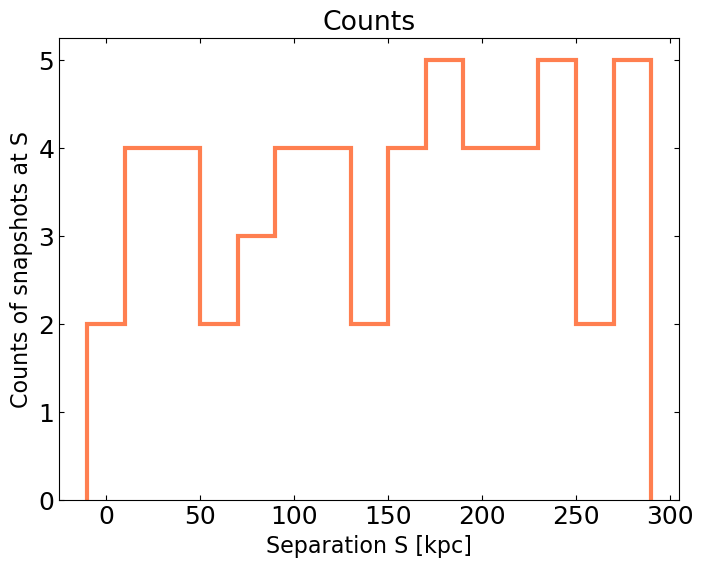

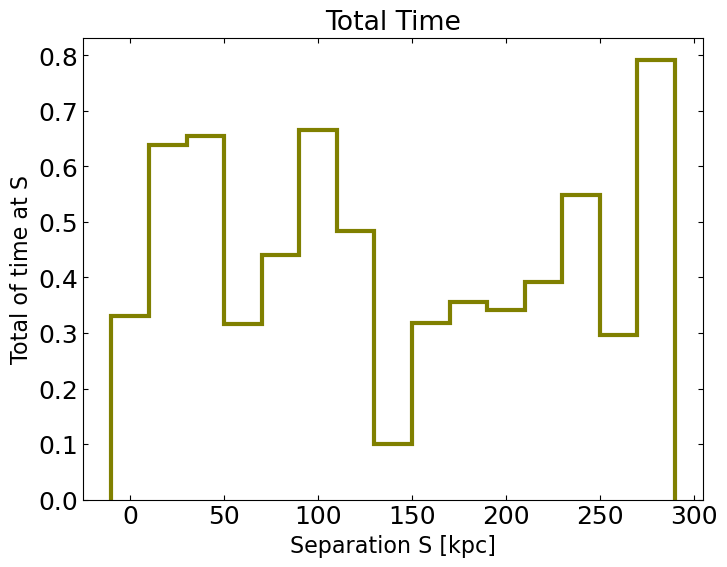

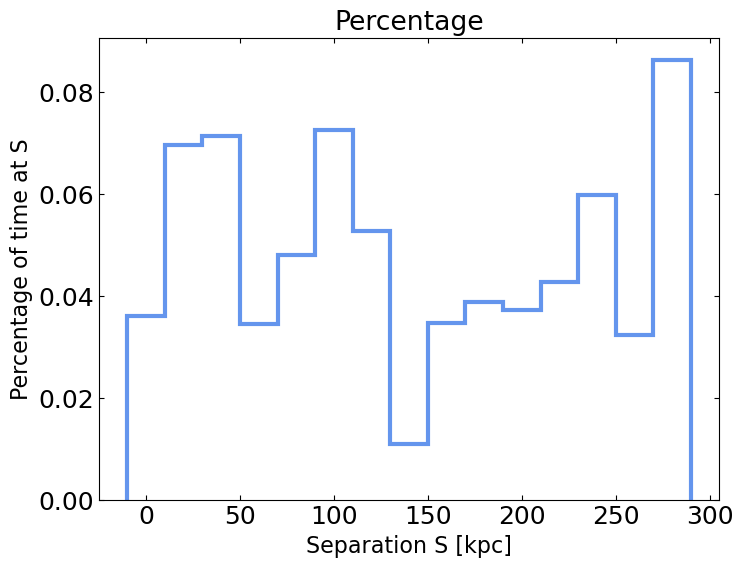

In [26]:
## first example of merged pair
xx = seps_masked
yy = elapsed_masked
bins = np.arange(-10,300,20)

unscaled_vals, unscaled_edges = np.histogram(xx,bins=bins)
scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy)
weighted_vals, weighted_edges = np.histogram(xx,bins=bins,weights=yy/np.sum(yy))

fig = plt.figure(figsize=(8,6))
plt.title("Counts")
plt.stairs(unscaled_vals,unscaled_edges,color="coral",lw=3)
plt.xlabel("Separation S [kpc]")
plt.ylabel("Counts of snapshots at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3)
plt.title("Total Time")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(weighted_vals,unscaled_edges,color="cornflowerblue",lw=3)
plt.title("Percentage")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Percentage of time at S")


print(unscaled_vals)
print(scaled_vals)

In [27]:
seps_shifted

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.62281476,   5.97926507,
        10.16760077,  21.99154963,  17.13413469,  27.83340596,
        43.98711832,  46.87983281,  36.2004837 ,  41.30782678,
        59.1167501 ,  75.74506704,  95.01645957, 108.04207611,
       112.33231094, 110.64704929,  98.42775339,  84.00636291,
        64.09989665,  70.01172396,  99.07474193, 117.8658706 ,
       151.58251945, 180.84111806, 204.00065532, 229.12080898,
       244.30706323, 268.94303249, 279.94551736, 282.58659091,
       287.28941435, 293.47738632, 308.31540014, 314.79777829,
       325.27218505, 332.62968748, 344.33020666, 353.78

## Full separation matrix hist ~ 

If I make an array of Elapsed Time that corresponds to each element of the separations array, then I make the separations for non zero and nan values, then I can mask the corresponding elapsed time array and then just histogram that, instead of having to loop through each pair. 

In [11]:
# array of the elapsed time with a nan value in the place of z=0
sep_matrix = check_dict["Separations"]

elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

print(np.shape(sep_matrix))
print(np.shape(elapsed_matrix))

(1330, 99)
(1330, 99)


In [12]:
nan_elapsed = np.isnan(elapsed_matrix)
nan_sep = np.isnan(sep_matrix)
zero_sep = sep_matrix == 0

matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep

elapsed_masked = elapsed_matrix[matrix_mask]
sep_masked = sep_matrix[matrix_mask]


In [13]:
print(np.shape(sep_masked))
print(np.shape(elapsed_masked))

(67049,)
(67049,)


[ 6036  6957  9216 11071  9655  7083  4867  3045  1913  1302   966   737
   584]
[ 938.56327725  982.23887025 1057.35501329 1187.14017828 1059.56111684
  808.38883162  573.84060668  371.61587201  239.00654212  167.78786795
  126.31380997   98.36409875   79.14913233]


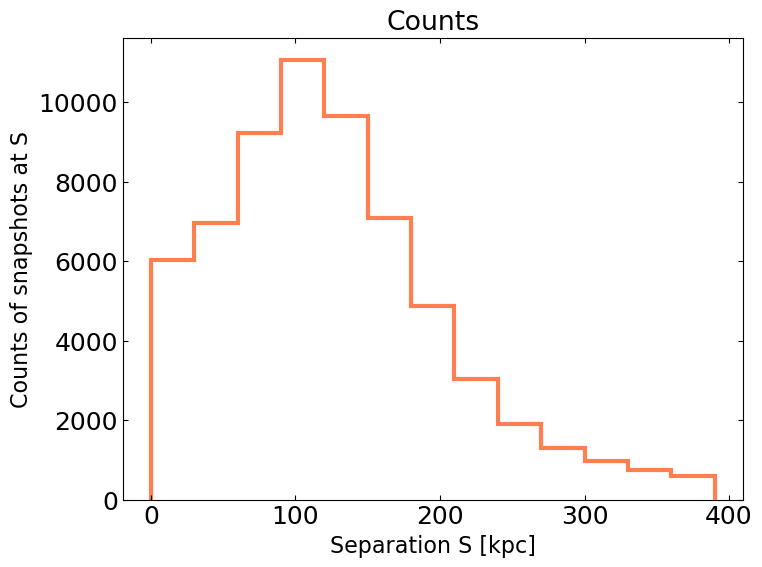

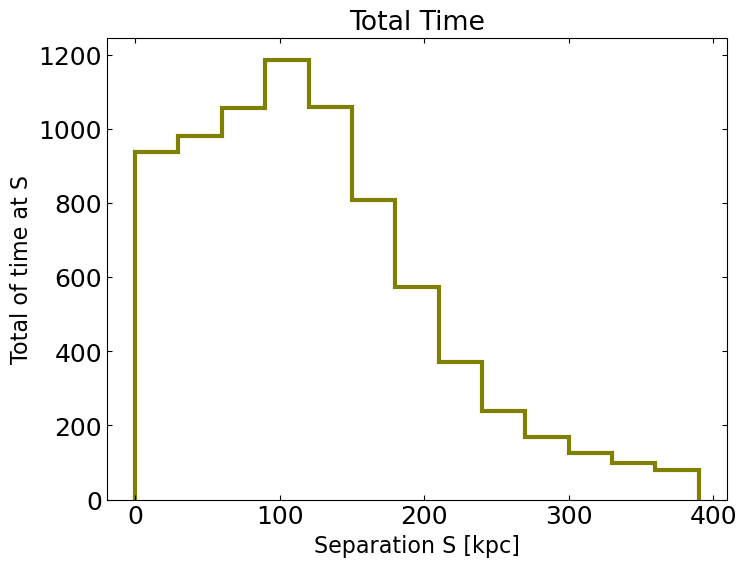

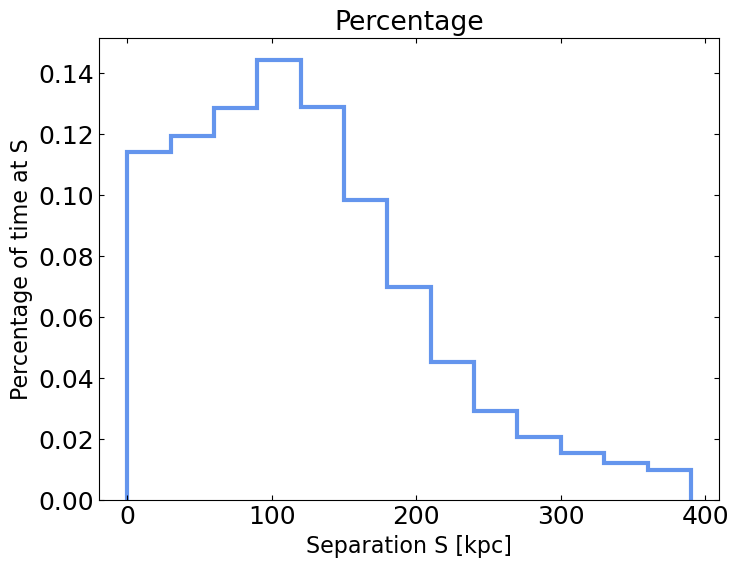

In [14]:
## first example of merged pair
xx = sep_masked
yy = elapsed_masked
bins = np.arange(0,400,30)

unscaled_vals, unscaled_edges = np.histogram(xx,bins=bins)
scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy)
weighted_vals, weighted_edges = np.histogram(xx,bins=bins,weights=yy/np.sum(yy))

fig = plt.figure(figsize=(8,6))
plt.title("Counts")
plt.stairs(unscaled_vals,unscaled_edges,color="coral",lw=3)
plt.xlabel("Separation S [kpc]")
plt.ylabel("Counts of snapshots at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3)
plt.title("Total Time")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S")


fig = plt.figure(figsize=(8,6))
plt.stairs(weighted_vals,unscaled_edges,color="cornflowerblue",lw=3)
plt.title("Percentage")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Percentage of time at S")


print(unscaled_vals)
print(scaled_vals)

## Merger vs. Non-merger hists

In [15]:
# array of the elapsed time with a nan value in the place of z=0
elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

sep_matrix = check_dict["Separations"]

nan_elapsed = np.isnan(elapsed_matrix)
nan_sep = np.isnan(sep_matrix)
zero_sep = sep_matrix == 0

matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
merge_mask = np.tile(np.array(check_dict["MergerFlag"],dtype='bool'),(99,1)).transpose()

elapsed_masked = elapsed_matrix[matrix_mask]
sep_masked = sep_matrix[matrix_mask]


In [21]:
check_dict.keys()

dict_keys(['GroupFlag', 'MergerFlag', 'MergerSnapshot', 'Separations', 'StellarMass1', 'StellarMass2', 'StellarMassRatio', 'SubfindID1', 'SubfindID2', 'Velocities'])

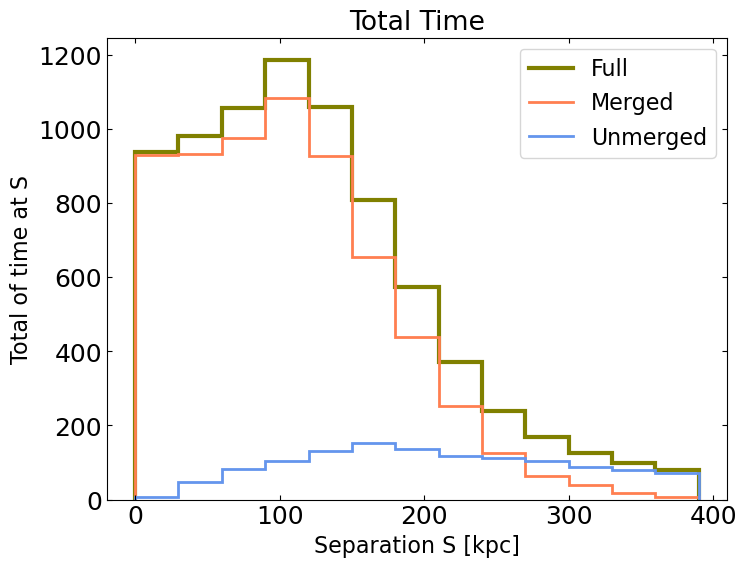

Note!! this is not scaled so times are non-physical


In [25]:
## merged vs. unmerged: TOTAL time spent at a separation 
xx = sep_masked
xx_merge = sep_matrix[matrix_mask&merge_mask]
xx_unmerge = sep_matrix[matrix_mask&~merge_mask]
yy = elapsed_masked
yy_merge = elapsed_matrix[matrix_mask&merge_mask]
yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]
bins = np.arange(0,400,30)

scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy)
merged_vals, scaled_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge)
unmerged_vals, scaled_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge)


fig = plt.figure(figsize=(8,6))
plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3,label="Full")
plt.stairs(merged_vals,unscaled_edges,color="coral",lw=2,label="Merged")
plt.stairs(unmerged_vals,unscaled_edges,color="cornflowerblue",lw=2,label="Unmerged")
plt.legend()
plt.title("Total Time")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S")
plt.savefig(f"/xdisk/gbesla/katiechambe/orbs/plots/3_timescale-analysis/fullsamples.pdf")
plt.show()

print("Note!! this is not scaled so times are non-physical")

^ this plot looks a little funny... first, it's the cumulative time each population spends at certain separations (so if two dwarfs are at 100 kpc for 2Gyr, the total time is 4Gyr)


What if we want the distribution to be normalized to the number of pairs there are, so that it shows the average time that each individual pair spends at a separation -> don't want to just divide by the total population, but by the number of mergers and non mergers

### Timescale per pair for merged and unmerged populations

Text(0, 0.5, 'Total of time at S per pair (average)')

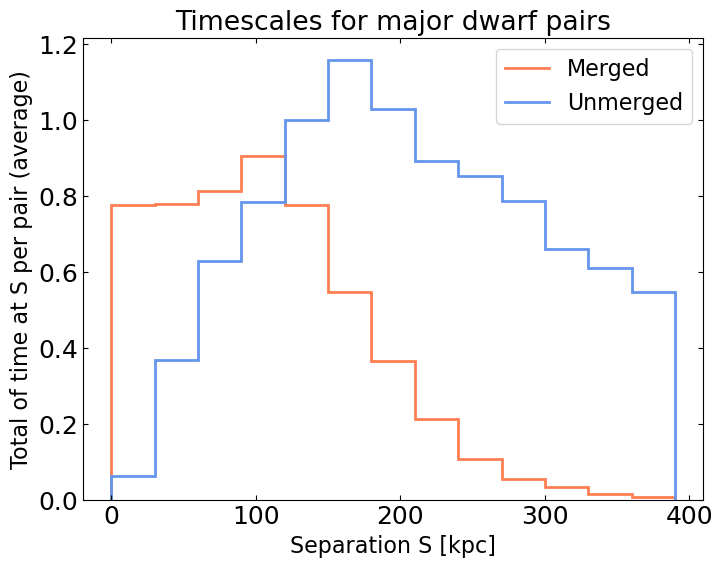

In [78]:
## merged vs. unmerged: TOTAL time spent at a separation 
xx = sep_masked
xx_merge = sep_matrix[matrix_mask&merge_mask]
xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

yy = elapsed_masked
yy_merge = elapsed_matrix[matrix_mask&merge_mask]
yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

num_pairs = np.shape(sep_matrix)[0]
num_mergers = np.sum(merge_mask,axis=0)[0]
num_unmerged = np.sum(~merge_mask,axis=0)[0]
bins = np.arange(0,400,30)

scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy/num_pairs)
merged_vals, scaled_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
unmerged_vals, scaled_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)


fig = plt.figure(figsize=(8,6))
# plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3,label="Full")
plt.stairs(merged_vals,unscaled_edges,color="coral",lw=2,label="Merged")
plt.stairs(unmerged_vals,unscaled_edges,color="cornflowerblue",lw=2,label="Unmerged")
plt.legend()
plt.title("Timescales for major dwarf pairs")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S per pair (average)")


In [68]:
xx

array([27.74290672, 14.77115846, 33.91586875, ..., 78.87172492,
       75.28791969, 69.59072036])

In [69]:
yy

array([0.18856991, 0.1390652 , 0.18227452, ..., 0.03022084, 0.04223414,
       0.05697626])

# Plot - Average time per pair

In [3]:
f = h5py.File(f"{paths.path_data}orbitdata_40.hdf5",'r')
orbit = {}
for key, val in f.items():
    orbit[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

In [ ]:
# array of the elapsed time with a nan value in the place of z=0
sep_matrix = orbit["Separations"]

elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

print(np.shape(sep_matrix))
print(np.shape(elapsed_matrix))

In [ ]:
# array of the elapsed time with a nan value in the place of z=0
elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

sep_matrix = check_dict["Separations"]

nan_elapsed = np.isnan(elapsed_matrix)
nan_sep = np.isnan(sep_matrix)
zero_sep = sep_matrix == 0

matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
merge_mask = np.tile(np.array(check_dict["MergerFlag"],dtype='bool'),(99,1)).transpose()

elapsed_masked = elapsed_matrix[matrix_mask]
sep_masked = sep_matrix[matrix_mask]


In [4]:
## merged vs. unmerged: TOTAL time spent at a separation 
xx = sep_masked
xx_merge = sep_matrix[matrix_mask&merge_mask]
xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

yy = elapsed_masked
yy_merge = elapsed_matrix[matrix_mask&merge_mask]
yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

num_pairs = np.shape(sep_matrix)[0]
num_mergers = np.sum(merge_mask,axis=0)[0]
num_unmerged = np.sum(~merge_mask,axis=0)[0]
bins = np.arange(0,400,30)

scaled_vals, scaled_edges = np.histogram(xx,bins=bins,weights=yy/num_pairs)
merged_vals, scaled_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
unmerged_vals, scaled_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)


fig = plt.figure(figsize=(8,6))
# plt.stairs(scaled_vals,unscaled_edges,color="olive",lw=3,label="Full")
plt.stairs(merged_vals,unscaled_edges,color="coral",lw=2,label="Merged")
plt.stairs(unmerged_vals,unscaled_edges,color="cornflowerblue",lw=2,label="Unmerged")
plt.legend()
plt.title("Timescales for major dwarf pairs")
plt.xlabel("Separation S [kpc]")
plt.ylabel("Total of time at S per pair (average)")


NameError: name 'sep_masked' is not defined

## Average "length" of orbit timescale

wait.... is this right? 

In [77]:
print("Total orbital timescale for mergers in Gyr:",sum(yy_merge/num_mergers))
print("Total orbital timescale for non-mergers in Gyr:",sum(yy_unmerge/num_unmerged))

Total orbital timescale for mergers in Gyr: 5.393125804940545
Total orbital timescale for non-mergers in Gyr: 13.32009199786203


In [72]:
sum(yy/num_pairs)
#/num_pairs

6.179862299274519